# BitBot



---



The Goal of the BitBot notebook is to explore the use of RNN (specificially LSTM: Long Short-Term Memory) in a time series analysis problem, and there is no better, or more diffiuclt, time series problem than trading options. The reason for using LSTM is that the structure of the RNN is such that it has feedback connections in its structure that allows for not only point predictions but allows predictions to be made keeping a series of data in mind




In [ ]:
from IPython.display import Image
Image(url='https://camo.githubusercontent.com/91ab6e0b7e38a89f95f3bf9a3954b9047e561a1008ab60befd442b02b3ec72b4/68747470733a2f2f73746174696330312e6e79742e636f6d2f696d616765732f323031352f30332f30382f73756e6461792d7265766965772f3038524f424f542f3038524f424f542d6d6173746572313035302e676966')

In [ ]:
# Make sure that you have all these libaries available to run the code successfully
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout

#Seaborn
import seaborn as sns
sns.set()

#Technical analysis library
!pip install pandas_ta
import pandas_ta as ta

#Financial charting
!pip install plotly
import plotly.graph_objects as go

First I will start out with the creation of a model built on a simple RNN, thereafter trying out different methods 


In [ ]:
#Gathering the data
df = pd.read_csv('/content/drive/MyDrive/BTCUSDT_D.csv')

#df =df[1000:]


'''
#Calc moving average
df['MA10'] = df['Close'].rolling(window=10).mean()
df['MA60'] = df['Close'].rolling(window=60).mean()
df.reset_index(inplace=True)

#Adding in technical indicators
# Create Custom Strategy
CustomStrategy = ta.Strategy(
    name="Momo and Volatility",
    description="SMA 50,200, BBANDS, RSI, MACD and Volume SMA 20",
    ta=[
        {"kind": "sma", "length": 50},
        {"kind": "sma", "length": 200},
        {"kind": "bbands", "length": 20},
        {"kind": "rsi"},
        {"kind": "macd", "fast": 8, "slow": 21},
        {"kind": "sma", "Close": "volume", "length": 20, "prefix": "VOLUME"},
    ]
)
# To run your "Custom Strategy"
df.ta.strategy(CustomStrategy)
'''



'\n#Calc moving average\ndf[\'MA10\'] = df[\'Close\'].rolling(window=10).mean()\ndf[\'MA60\'] = df[\'Close\'].rolling(window=60).mean()\ndf.reset_index(inplace=True)\n\n#Adding in technical indicators\n# Create Custom Strategy\nCustomStrategy = ta.Strategy(\n    name="Momo and Volatility",\n    description="SMA 50,200, BBANDS, RSI, MACD and Volume SMA 20",\n    ta=[\n        {"kind": "sma", "length": 50},\n        {"kind": "sma", "length": 200},\n        {"kind": "bbands", "length": 20},\n        {"kind": "rsi"},\n        {"kind": "macd", "fast": 8, "slow": 21},\n        {"kind": "sma", "Close": "volume", "length": 20, "prefix": "VOLUME"},\n    ]\n)\n# To run your "Custom Strategy"\ndf.ta.strategy(CustomStrategy)\n'

In [ ]:
df.dtypes

Currency                object
Date                    object
Closing Price (USD)    float64
24h Open (USD)         float64
24h High (USD)         float64
24h Low (USD)          float64
dtype: object

In [ ]:
df = df.rename(index=str, columns={"Closing Price (USD)": "Close", "24h Open (USD)": "Open","24h High (USD)": "High","24h Low (USD)": "Low"})

In [ ]:
df.tail()

,Currency,Date,Close,Open,High,Low
1741,BTC,2021-03-14,60743.041825,57227.233450,61556.594492,56124.149994
1742,BTC,2021-03-15,60197.901992,60972.491282,61453.058342,59275.703832
1743,BTC,2021-03-16,56300.334109,58962.488465,60570.693653,54790.329313
1744,BTC,2021-03-17,56639.783950,55668.623532,56821.882435,53350.367726
1745,BTC,2021-03-18,58567.283781,56908.565018,58923.548931,54201.701634


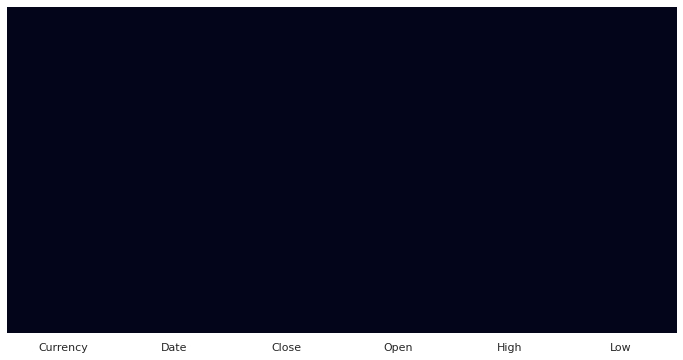

In [ ]:
#Checking for null values using seaborn
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False)

No problems here, onwards!

In [ ]:
#Cursory exploration of price performance over time for full set of data
fig = go.Figure(data=go.Ohlc(x=df['Date'],
                    open=df['Open'],
                    high=df['High'],
                    low=df['Low'],
                    close=df['Close']))
fig.show()

In [ ]:
#splitting data into training and testing sets
train_data,test_data=train_test_split(df,test_size=0.2)
print(train_data.shape[0])
print(test_data.shape[0])

#I've done the below split by hand as the scikit learn split used above scrambles the data, which is obviously not helpful in a time series analysis
train_data_full = df[:train_data.shape[0]]
train_data = train_data_full[['Close']]
test_data_full = df[train_data.shape[0]:]
test_data = test_data_full[['Close']]



1396
350


In [ ]:
#Cursory exploration of price performance over time for training set
fig = go.Figure(data=go.Ohlc(x=train_data_full['Date'],
                    open=train_data_full['Open'],
                    high=train_data_full['High'],
                    low=train_data_full['Low'],
                    close=train_data_full['Close']))
fig.show()

In [ ]:
#Cursory exploration of price performance over time for testing set
fig = go.Figure(data=go.Ohlc(x=test_data_full['Date'],
                    open=test_data_full['Open'],
                    high=test_data_full['High'],
                    low=test_data_full['Low'],
                    close=test_data_full['Close']))
fig.show()

In [ ]:
# Normalizing data, scale between 0 and 1:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))
training_data_scaled = sc.fit_transform(train_data)

In [ ]:
training_data_scaled.shape

(1396, 1)

In [ ]:
X_train = []
y_train = []
for i in range(60, train_data.shape[0]):
  X_train.append(training_data_scaled[i-60:i, 0])
  y_train.append(training_data_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
# Building Model:
model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.summary()



#Compiling Model
model.compile(loss='mse', optimizer='adam')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 60, 96)            37632     
_________________________________________________________________
dropout_12 (Dropout)         (None, 60, 96)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 60, 96)            74112     
_________________________________________________________________
dropout_13 (Dropout)         (None, 60, 96)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 60, 96)            74112     
_________________________________________________________________
dropout_14 (Dropout)         (None, 60, 96)            0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 96)               

I have tested a range of epochs and the current number of epochs that is performing best is approximately 50

In [ ]:
modelo = model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
42/42 [==============================] - 13s 168ms/step - loss: 0.0281
Epoch 2/50
42/42 [==============================] - 7s 167ms/step - loss: 0.0047
Epoch 3/50
42/42 [==============================] - 7s 167ms/step - loss: 0.0044
Epoch 4/50
42/42 [==============================] - 7s 168ms/step - loss: 0.0035
Epoch 5/50
42/42 [==============================] - 7s 168ms/step - loss: 0.0034
Epoch 6/50
42/42 [==============================] - 7s 167ms/step - loss: 0.0028
Epoch 7/50
42/42 [==============================] - 7s 169ms/step - loss: 0.0027
Epoch 8/50
42/42 [==============================] - 7s 168ms/step - loss: 0.0024
Epoch 9/50
42/42 [==============================] - 7s 167ms/step - loss: 0.0024
Epoch 10/50
42/42 [==============================] - 7s 169ms/step - loss: 0.0020
Epoch 11/50
42/42 [==============================] - 7s 168ms/step - loss: 0.0021
Epoch 12/50
42/42 [==============================] - 7s 167ms/step - loss: 0.0022
Epoch 13/50
42/42 [=====

Ploting the Loss to visualize how well the training went

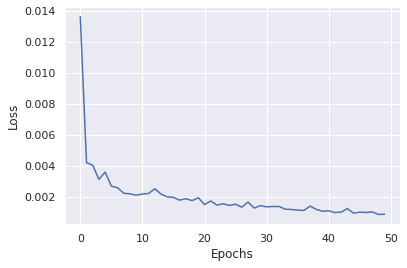

In [ ]:
plt.plot(modelo.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

I would like to look into methods to smooth this loss function out, but it might be a function of how volatile the price of bitcoin is

In [ ]:
dataset_total = pd.concat([train_data['Close'], test_data['Close']], axis=0)
inputs = dataset_total[len(dataset_total) - len(test_data) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, test_data.shape[0]):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
#After formatting test data we predict using our x_test set
predicted_stock_price_full = model.predict(X_test)


But before plot our predictions, we need to make a inverse_transform() in the predictions array, because we make predictions using the Scale, so our predictions are between 0 and 1, so we need to change back to the untransformed values.

In [ ]:
predicted_stock_price = sc.inverse_transform(predicted_stock_price_full)
#print(predicted_stock_price)

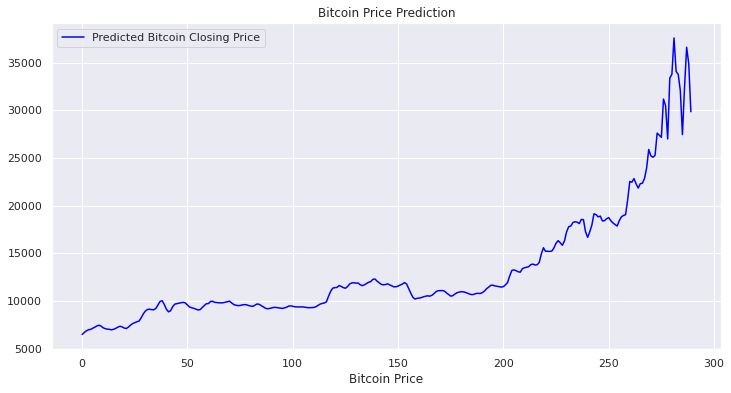

In [ ]:
#plot results
plt.figure(figsize=(12, 6))

plt.plot(predicted_stock_price, color='blue', label='Predicted Bitcoin Closing Price')

plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.xlabel('Bitcoin Price')
plt.legend()
plt.show()

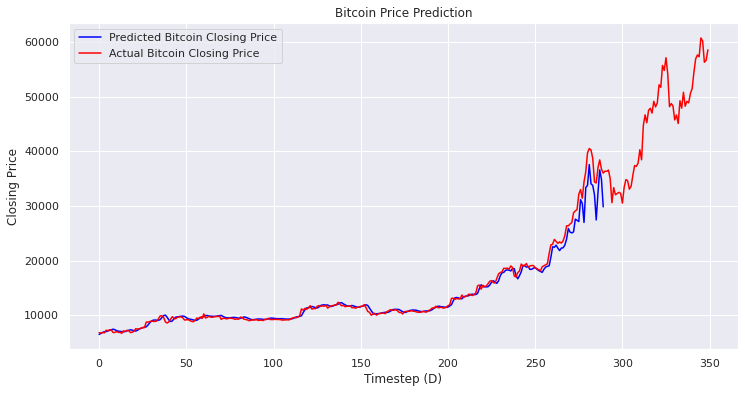

In [ ]:

real_stock_price = test_data['Close'].values
#plot results
plt.figure(figsize=(12, 6))

plt.plot(predicted_stock_price, color='blue', label='Predicted Bitcoin Closing Price')
plt.plot(real_stock_price, color='red', label='Actual Bitcoin Closing Price')

plt.title('Bitcoin Price Prediction')
plt.xlabel('Timestep (D)')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

**Thoughts on future development:** We can see at the end of the testing set that the model is out of its depth, having not seen such volatile behaviour before. If we want to increase accuracy we can attempt to change the way we train the model, at the moment this is using the classic 80/20 split. This provides contiguous data all along the set. Maybe we should be breaking up the data into chunks that give the model a better sample of volatility within the set.